# `Classification Model`
* <b>File Name</b>                          : Reference_implementation of mnist model in Azure ML Studio
* <b>Date of creation(dd-mm-yyyy)</b>       : 03-06-2022
* <b>Author Name/Dept</b>                   : AIShield
* <b>Organization</b>                       : BGSW
* <b>Description</b>                        : Source Code of reference implementation
* <b>Copyright</b>                          : Copyright 2022 Bosch Global Software Technologies Private Limited. All Rights Reserved.

###  `Metadata`
* Dataset: mnist
* Size of training set: 54,000
* Size of testing set : 10,000
* Size of training set: 6,000
* Number of class : 10
* Original Model: CNN

### `Outcomes`
* Accuracy of model: 0.97

In [ ]:
"""
Description: commands to install all the packages, remove comments to install all the libraries. Tested with Python 3.7.13
"""
!pip install azureml-widgets==1.41.0
!pip install azureml-sdk==1.41.0
!pip install tensorflow==2.5.0
!pip install pandas==1.3.5
!pip install numpy==1.19.5
!pip install matplotlib==3.5.2

### `importing libraries`

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import azureml
from azureml.core import Workspace
from azureml.core import Experiment
import urllib.request
import struct
from azureml.core.dataset import Dataset
from azureml.exceptions import UserErrorException
import shutil
from azureml.core import Environment
from azureml.core import ScriptRunConfig
import gzip
import zipfile
import numpy as np
import time
import random
import pandas as pd
import cv2
import requests
import json
from azureml.core import Workspace
from azureml.core import Dataset
from azureml.data.datapath import DataPath
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.widgets import RunDetails
import shutil
from azureml.core.model import Model
import glob
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.model import Model



### `check core SDK version number`


In [2]:
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.41.0


###  `Initialize workspace`
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [ ]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name,
      'Azure region: ' + ws.location,
      'Subscription id: ' + ws.subscription_id,
      'Resource group: ' + ws.resource_group, sep = '\n')

### `Create an Azure ML experiment`
Let's create an experiment named "tf-mnist" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [34]:
script_folder = './tf-mnist-exp'
os.makedirs(script_folder, exist_ok=True)
exp = Experiment(workspace=ws, name='tf-mnist-exp')

### `Download MNIST dataset`
In order to train on the MNIST dataset we will first need to download it from azuremlopendatasets blob directly and save them in a `data` folder locally.

In [304]:
data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

In [ ]:
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'))

In [10]:
# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

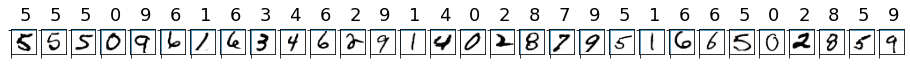

In [11]:
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images-idx3-ubyte.gz'), False) / np.float32(255.0)
X_test = load_data(os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'), False) / np.float32(255.0)
y_train = load_data(os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'), True).reshape(-1)

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

### `Create a Dataset for Files`
A Dataset can reference single or multiple files in your datastores or public urls. The files can be of any format. Dataset provides you with the ability to download or mount the files to your compute. By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred. [Learn More](https://aka.ms/azureml/howto/createdatasets)

In [12]:
web_paths = ['https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

You may want to regiester datasets using the register() method to your workspace so they can be shared with others, reused across various experiments, and `referred to by name in your training script` .
You can try get the dataset first to see if it's already registered.

In [170]:
dataset_registered = False
try:
    temp = Dataset.get_by_name(workspace = ws, name = 'mnist-dataset-exp')
    dataset_registered = True
except UserErrorException:
    print("The dataset mnist-dataset is not registered in workspace yet.")

if not dataset_registered:
    dataset = dataset.register(workspace = ws,
                               name = 'mnist-dataset-exp',
                               description='training and test dataset',
                               create_new_version=True)
# list the files referenced by dataset
dataset.to_path()

['/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz']

### `Create or Attach existing AmlCompute`
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. 

In [194]:
# choose a name for your cluster
cluster_name = "hd-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_D8as_v4",max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# can poll for a minimum number of nodes and for a specific timeout. 
# if no min node count is provided it uses the scale settings for the cluster
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Creating a new compute target...
InProgress.
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Resizing', 'allocationStateTransitionTime': '2022-05-27T11:05:09.362000+00:00', 'errors': None, 'creationTime': '2022-05-27T11:05:08.871000+00:00', 'modifiedTime': '2022-05-27T11:05:12.522787+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT1800S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D8AS_V4'}


### `To delete computer instance after use`

In [257]:
# compute_target.delete()

Current provisioning state of AmlCompute is "Deleting"

Current provisioning state of AmlCompute is "Deleting"



In [195]:
compute_target.get_status().vm_size

'STANDARD_D8AS_V4'

In [196]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

hd-cluster AmlCompute Succeeded


### `Copy the training files into the script folder`

In [78]:
# the training logic is in the mnist.py file.
shutil.copy('./mnist.py', script_folder)

'./tf-mnist-exp\\mnist.py'

### `Create an environment`

we will use one of Azure ML's curated TensorFlow environments for training. [Curated environments](https://docs.microsoft.com/azure/machine-learning/how-to-use-environments#use-a-curated-environment) are available in your workspace by default. Specifically, we will use the TensorFlow 2.0 GPU curated environment.

In [184]:
tf_env = Environment.get(ws, name='AzureML-TensorFlow-2.0-GPU')

In [185]:
print(tf_env)

Environment(Name: AzureML-TensorFlow-2.0-GPU,
Version: 44)


### `Configure the training job`

Create a ScriptRunConfig object to specify the configuration details of your training job, including your training script, environment to use, and the compute target to run on.

In [199]:
args = ['--data-folder', dataset.as_named_input('mnist').as_mount(),
        '--batch-size', 64,
        '--epochs',20,
        '--learning-rate', 0.01]

src = ScriptRunConfig(source_directory=script_folder,
                      script='mnist.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=tf_env)

### `Submit job to run`

Submit the ScriptRunConfig to an Azure ML experiment to kick off the execution.

In [200]:
run = exp.submit(src)

### `Show logs in a widget format`

widget will automatically update ever 10-15 seconds, always showing you the most up-to-date information about the run

In [202]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Current provisioning state of AmlCompute is "Deleting"



In [203]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
tf-mnist-exp,tf-mnist-exp_1653649582_2e250403,azureml.scriptrun,Queued,Link to Azure Machine Learning studio,Link to Documentation


In [ ]:
run.wait_for_completion(show_output=True)

In [ ]:
run.get_details()

In [207]:
run.get_file_names()

['outputs/model/saved_model.pb',
 'outputs/model/variables/variables.data-00000-of-00001',
 'outputs/model/variables/variables.index',
 'system_logs/cs_capability/cs-capability.log',
 'system_logs/data_capability/data-capability.log',
 'system_logs/data_capability/rslex.log',
 'system_logs/data_capability/rslex.log.2022-05-27-11',
 'system_logs/hosttools_capability/hosttools-capability.log',
 'system_logs/lifecycler/execution-wrapper.log',
 'system_logs/lifecycler/lifecycler.log',
 'user_logs/std_log.txt']

### `Download the saved model`

In [209]:
run.download_files(prefix='outputs/model', output_directory='./model123', append_prefix=False)


In [13]:
imported_model = tf.saved_model.load('./model123')

In [14]:
def convert_to_numpy(data_dir, images_file, labels_file):
    """Byte string to numpy arrays"""
    with gzip.open(images_file, "rb") as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzip.open(labels_file, "rb") as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)

    return (images, labels)


def mnist_to_numpy(data_dir, train):
    """Load raw MNIST data into numpy array

    Args:
        data_dir (str): directory of MNIST raw data.
            This argument can be accessed via SM_CHANNEL_TRAINING

        train (bool): use training data

    Returns:
        tuple of images and labels as numpy array
    """

    if train:
        images_file = "train-images-idx3-ubyte.gz"
        images_file_path = glob.glob(os.path.join(data_folder, '**/train-images-idx3-ubyte.gz'),
                              recursive=True)[0]
        labels_file = "train-labels-idx1-ubyte.gz"
        labels_file_path = glob.glob(os.path.join(data_folder, '**/train-labels-idx1-ubyte.gz'),
                              recursive=True)[0]

        
    else:
        images_file = "t10k-images-idx3-ubyte.gz"
        images_file_path = glob.glob(os.path.join(data_folder, '**/t10k-images-idx3-ubyte.gz'),
                              recursive=True)[0]

        labels_file = "t10k-labels-idx1-ubyte.gz"
        labels_file_path = glob.glob(os.path.join(data_folder, '**/t10k-labels-idx1-ubyte.gz'),
                              recursive=True)[0]

        
    print('images_file_path :',images_file_path)
    print('labels_file_path :',labels_file_path)
    return convert_to_numpy(data_dir, images_file_path, labels_file_path)

def normalize(x, axis):
    eps = np.finfo(float).eps

    mean = np.mean(x, axis=axis, keepdims=True)
    # avoid division by zero
    std = np.std(x, axis=axis, keepdims=True) + eps
    return (x - mean) / std


In [15]:
data_folder = 'data'
x_train, y_train = mnist_to_numpy(data_dir=data_folder, train=True)
x_test, y_test = mnist_to_numpy(data_dir=data_folder, train=False)

x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

# normalize the inputs to mean 0 and std 1
x_train, x_test = normalize(x_train, (1, 2)), normalize(x_test, (1, 2))

# expand channel axis
# tf uses depth minor convention
x_train, x_test = np.expand_dims(x_train, axis=3), np.expand_dims(x_test, axis=3)


images_file_path : data_exp_123\train-images-idx3-ubyte.gz
labels_file_path : data_exp_123\train-labels-idx1-ubyte.gz
images_file_path : data_exp_123\t10k-images-idx3-ubyte.gz
labels_file_path : data_exp_123\t10k-labels-idx1-ubyte.gz


### `Predict on y_test after loading the downloading the model`

In [16]:
pred = imported_model(x_test)
y_hat = np.argmax(pred, axis=1)

# print the first 30 labels and predictions
print('labels:  \t', y_test[:30])
print('predictions:\t', y_hat[:30])

labels:  	 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
predictions:	 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


In [17]:
print("Accuracy on the test set:", np.average(y_hat == y_test))

Accuracy on the test set: 0.9733


In [18]:
data_dir="data"
images_file = "t10k-images-idx3-ubyte.gz"
labels_file = "t10k-labels-idx1-ubyte.gz"

with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

with gzip.open(os.path.join(data_dir, labels_file), "rb") as f:
    labels = np.frombuffer(f.read(), np.uint8, offset=8)

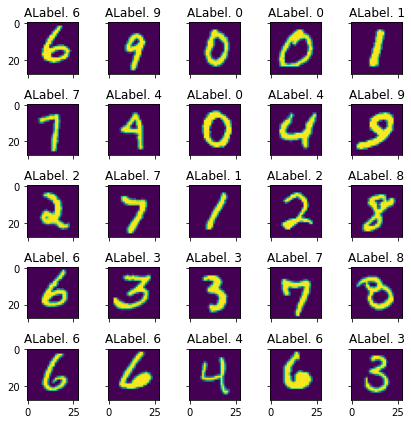

In [19]:
'''
Description: Visualize few random data sample
'''
rows=5

random_indices=random.sample(range(images.shape[0]),rows*rows)
sample_images=images[random_indices,:]
sample_images = np.expand_dims(sample_images, axis=-1) 
sample_labels=labels[random_indices]

fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(6,6),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_images[i,:])
    axs[subplot_row,subplot_col].set_title("ALabel. %d" % sample_labels[i])
plt.tight_layout()

### `Save data, label and model in zip `

In [94]:
%%time
"""
Description: Save data and label
"""
label=pd.DataFrame()
img_name = []
img_label = [] 

if not os.path.isdir("data"):
    os. makedirs("data")
    
for i in range(images.shape[0]):
    cv2.imwrite(os.path.join("data",str(i)+".jpg") ,images[i]*255.0) # don't use plt.imread otheriwse while loading the saved images , and passing to model there is accuarcy drop 
    img_name.append(str(i)+".jpg")
    img_label.append(labels[i])
label['image'] = img_name
label["label"] = np.array(img_label)

#write orig_label dataframe
label.to_csv(os.path.join("label.csv"),index=False)

Wall time: 30.5 s


In [226]:
"""
Description: Zip data
"""
def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))
      
zipf = zipfile.ZipFile('data.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('data', zipf)
zipf.close()

In [227]:
"""
Description: Zip label
"""
zipfile.ZipFile('label123.zip', mode='w').write("label.csv")

In [ ]:
"""
Description: Zip model
"""
shutil.make_archive(base_name='model', format='zip', root_dir='model123')

### `AIShield API Call`

In [20]:
"""
Description: AIShield API URL and subscription key
""" 
url="https://xxxxxxxxxxxxxxxxx/VulnerabiltyReport"
headers={'Cache-Control': 'no-cache',
'Ocp-Apim-Subscription-Key': "xxxxxxxxxxxxxxxxxxxx"
}

In [22]:
"""
Description: Payload for AIShield VulnerabilityReport api call
"""
payload={}
payload['input_dimensions']=str((28,28,1))
payload['number_of_classes']=str(10)
payload['attack_type']="Blackbox"
payload['number_of_attack_queries']=100000
payload['model_framework']='Tensorflow'
payload['vulnerability_threshold']="0"
payload['normalize_data']="yes"
payload['defense_bestonly']="no"
payload['encryption_strategy']=0
payload['use_model_api']="no"
payload['model_api_details']=""

In [23]:
payload

{'input_dimensions': '(28, 28, 1)',
 'number_of_classes': '10',
 'attack_type': 'Blackbox',
 'number_of_attack_queries': 100000,
 'model_framework': 'Tensorflow',
 'vulnerability_threshold': '0',
 'normalize_data': 'yes',
 'defense_bestonly': 'no',
 'encryption_strategy': 0,
 'use_model_api': 'no',
 'model_api_details': ''}

In [24]:
"""
Description: Files path
"""
cur_dir=os.getcwd()
data_path=os.path.join(cur_dir,'data.zip') #full path of data zip
label_path=os.path.join(cur_dir,'label.zip') #full path of label zip
model_path=os.path.join(cur_dir,'model123.zip') #full path of model zip

In [25]:
"""
Description: Files for AIShield VulnerabilityReport api call
"""
model_name=os.path.split(model_path)[1] #model file name
data_name=os.path.split(data_path)[1] #data file name
label_name=os.path.split(label_path)[1] #label file name

files=[
  ('data_zip',(data_name,open(data_path,'rb'),'application/x-zip-compressed')),
  ('model_zip',(model_name,open(model_path,'rb'),'application/x-zip-compressed')),
  ('label_zip',(label_name,open(label_path,'rb'),'application/x-zip-compressed'))
  ]

In [1]:

"""
Description: Hit AIShield VulnerabilityReport api
"""
new_request = requests.request(method="POST", url=url, params=payload, files=files,headers=headers)
new_request=json.loads(new_request.text)
for k, v in new_request.items():
    print("* {} : {}".format(k,v))

* attack_type : Blackbox
* defense_bestonly : no
* encryption_strategy : 0
* input_dimensions : (28, 28, 1)
* job_id : xxxxxxxxxxxxxxxxxxxxxxxx
* model_framework : Tensorflow
* monitor_link : https://xxxxxxx/xxxxxxxxxxxx
* normalize_data : yes
* number_of_attack_queries : 100000
* number_of_classes : 10
* use_model_api : no
* vulnerability_threshold : 0


In [3]:
"""
Description: Get job id from api response
"""
job_id=new_request['job_id']
print(f"Job id : {job_id}")

Job id : xxxxxxxxxxxxxxxxxxxxxxxxxxxx


In [30]:
"""
Description: Query GetProcessDetail api and Monitor progress for job id
"""
job_status_url=url[:-18]+"JobStatusDetailed?JobID=" +job_id

#status dictionary
status_dictionary={
 'ModelExploration_Status': 'na',
 'SanityCheck_Status': 'na',
 'QueryGenerator_Status': 'na',
 'VunerabilityEngine_Status': 'na', 
 'DefenseReport_Status': 'na',
 'IntegratedModelGenerator_Status':'na',

}
while(True):
    time.sleep(5) 
    job_status_response = requests.request("GET", job_status_url, params={},headers=headers)

    job_status_payload=json.loads(job_status_response.text)
    failing_key='ModelExploration_Status'
    for key in status_dictionary.keys():
        if status_dictionary[key]=='na':
            if job_status_payload[key]=='completed' or job_status_payload[key]=='passed':
                status_dictionary[key]=job_status_payload[key]
                print(str(key), ":",status_dictionary[key])
            elif job_status_payload[key]=='failed':
                failing_key=key
                status_dictionary[key]=job_status_payload[key]
                print(str(key), ":",status_dictionary[key])

    if status_dictionary[failing_key]=='failed':
        break

    if status_dictionary['VunerabilityEngine_Status']=='passed' or status_dictionary['VunerabilityEngine_Status']=='completed' and job_status_payload['CurrentStatus']=="Defense generation is not triggered" :
        print("\n Vulnerability score {} failed to cross vulnerability threshoold of {}".format(job_status_payload['VulnerabiltyScore'],job_meta_data['vulnerability_threshold']))
        break
    if job_status_payload['IntegratedModelGenerator_Status']=='completed':
        break

ModelExploration_Status : completed
SanityCheck_Status : passed
QueryGenerator_Status : completed
VunerabilityEngine_Status : completed
DefenseReport_Status : completed
IntegratedModelGenerator_Status : completed


### `Get all Vulnerability report and upload to Azure ML`

In [271]:
job_artifact_url=url[:-18]+"GetReport?JobID=" +job_id+"&ReportType=Vulnerability&fileFormat=2"

In [272]:
job_status_response = requests.request("GET", job_artifact_url, params={},headers=headers)

In [279]:
print(job_status_response)

<Response [200]>


In [280]:
with open('reports/Vulnerability.pdf', 'wb') as f:
    f.write(job_status_response.content)

In [283]:

ws = Workspace.from_config()
datastore = ws.get_default_datastore()

Dataset.File.upload_directory(src_dir='reports', 
                              target=DataPath(datastore, "mnist-reports"))

Validating arguments.
Arguments validated.
Uploading file to mnist-reports
Uploading an estimated of 1 files
Uploading reports\Vulnerability.pdf
Uploaded reports\Vulnerability.pdf, 1 files out of an estimated total of 1
Uploaded 1 files
Creating new dataset


{
  "source": [
    "('workspaceblobstore', '/mnist-reports')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ]
}

### `Get defense model artifacts`

In [31]:
job_artifact_url=url[:-18]+"GetReport?JobID=" +job_id+"&ReportType=Defense_artifact&fileFormat=0"

In [33]:
job_status_response = requests.request("GET", job_artifact_url, params={},headers=headers)

In [34]:
with open('defense_artifact.zip', "wb") as f:
  f.write(job_status_response.content)

shutil.unpack_archive('defense_artifact.zip', 'defense_artifact')

### `Workflow for deploying a model`

1. Register the model.
2. Prepare an entry script.
3. Prepare an inference configuration.
4. Deploy the model locally to ensure everything works.
5. Choose a compute target.
6. Deploy the model to the cloud.
7. Test the resulting web service.

### `Register Original Model`


In [35]:
model = Model.register(ws, model_name='tf-mnist-model-exp-check', model_path="output/model/")

Registering model tf-mnist-model-exp-check


### `Deploy model in ACI`
Now we are ready to deploy the model as a web service running in Azure Container Instance [ACI](https://azure.microsoft.com/en-us/services/container-instances/). Azure Machine Learning accomplishes this by constructing a Docker image with the scoring logic and model baked in.
#### `Create score.py`
First, we will create a scoring script that will be invoked by the web service call. 

* Note that the scoring script must have two required functions, `init()` and `run(input_data)`. 
  * In `init()` function, you typically load the model into a global object. This function is executed only once when the Docker container is started. 
  * In `run(input_data)` function, the model is used to predict a value based on the input data. The input and output to `run` typically use JSON as serialization and de-serialization format but you are not limited to that.

### `preparing the entry script`

In [36]:
import numpy as np
import os
import tensorflow as tf

from azureml.core.model import Model

def init():
    global tf_model
    model_root = os.getenv('AZUREML_MODEL_DIR')
    # the name of the folder in which to look for tensorflow model files
    tf_model_folder = 'model'
    
    tf_model = tf.saved_model.load(os.path.join(model_root, tf_model_folder))

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'], dtype=np.float32)
    
    # make prediction
    out = tf_model(data)
    y_hat = np.argmax(out, axis=1)

    return y_hat.tolist()

### `Create myenv.yml`
We also need to create an environment file so that Azure Machine Learning can install the necessary packages in the Docker image which are required by your scoring script. In this case, we need to specify packages `numpy`, `tensorflow`.

In [37]:
from azureml.core.runconfig import CondaDependencies

cd = CondaDependencies.create()
cd.add_conda_package('numpy')
cd.add_pip_package('tensorflow==2.0.0')
cd.add_pip_package("azureml-defaults")
cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

print(cd.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - tensorflow==2.0.0
  - azureml-defaults
- numpy
channels:
- anaconda
- conda-forge



### `Deploy original model to ACI`
We are almost ready to deploy. Create the inference configuration and deployment configuration and deploy to ACI. This cell will run for about 7-8 minutes.

In [68]:


myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=2, 
                                               memory_gb=2, 
                                               tags={'name':'mnist', 'framework': 'TensorFlow '},
                                               description='Tensorflow on MNIST')

service = Model.deploy(workspace=ws, 
                           name='tf-mnist-svc', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)

service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-06-02 16:13:48+05:30 Creating Container Registry if not exists.
2022-06-02 16:13:49+05:30 Registering the environment.
2022-06-02 16:13:50+05:30 Generating deployment configuration.
2022-06-02 16:13:51+05:30 Submitting deployment to compute.
2022-06-02 16:13:57+05:30 Checking the status of deployment tf-mnist-svc..
2022-06-02 16:15:54+05:30 Checking the status of inference endpoint tf-mnist-svc.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [69]:
print(service.get_logs())

2022-06-02T10:45:47,544021400+00:00 - gunicorn/run 
Dynamic Python package installation is disabled.
Starting HTTP server
2022-06-02T10:45:47,549638200+00:00 - iot-server/run 
2022-06-02T10:45:47,550481000+00:00 - rsyslog/run 
2022-06-02T10:45:47,557363700+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2022-06-02T10:45:47,787141900+00:00 - iot-server/finish 1 0
2022-06-02T10:45:47,789207700+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 20.1.0
Listening at: http://127.0.0.1:31311 (74)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 103
SPARK_HOME not set. Skipping PySpark Initialization.
Initializing logger
2022-06-02 10:45:51,931 | root | INFO | Starting up app insights client
logging socket was found. logging is available.
logging socket was found. logging is available.
2022-06-02 10:45:51,932 | root | INFO | Starting up request id generator
2022-06-02 10:45:51,932 | root | INFO | Sta

In [41]:
import json

# find 30 random samples from test set
test_data = np.random.rand(10, 28, 28, 1)
test_samples = json.dumps({"data": x_test.tolist()})
test_samples = bytes(test_samples, encoding='utf8')


n = 30
sample_indices = np.random.permutation(x_test.shape[0])[0:n]

test_samples = json.dumps({"data": x_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')


[1, 1, 2, 2, 0, 9, 2, 5, 8, 0, 0, 7, 1, 7, 2, 3, 7, 6, 3, 0, 0, 2, 6, 8, 9, 0, 2, 7, 5, 5]


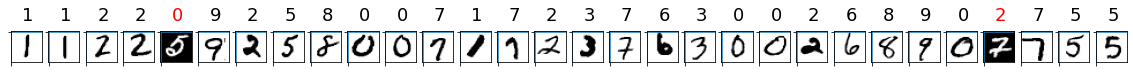

In [42]:

# predict using the deployed model
# sanity check
result = service.run(input_data=test_samples)
print(result)

# # compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

### `convert h5 to pb`

In [44]:
loaded_defense_model = tf.keras.models.load_model('defense_artifact/defense_model.h5')

In [45]:
model_version = '3'
export_dir = 'defense_artifact/Servo/' + model_version
tf.saved_model.save(loaded_defense_model, export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: defense_artifact/Servo/3\assets


### `register defense model`

In [46]:
defensemodel = Model.register(ws, model_name='defense-model', model_path="defense_artifact/Servo/model/")

Registering model defense-model


### `deploying the defense model`

In [71]:
defenseservice = Model.deploy(workspace=ws, 
                           name='defense-svc', 
                           models=[defensemodel], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)

defenseservice.wait_for_deployment(True)
print(defenseservice.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-06-02 16:17:27+05:30 Creating Container Registry if not exists.
2022-06-02 16:17:27+05:30 Registering the environment.
2022-06-02 16:17:27+05:30 Use the existing image.
2022-06-02 16:17:28+05:30 Generating deployment configuration.
2022-06-02 16:17:29+05:30 Submitting deployment to compute.
2022-06-02 16:17:35+05:30 Checking the status of deployment defense-svc..
2022-06-02 16:19:38+05:30 Checking the status of inference endpoint defense-svc.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


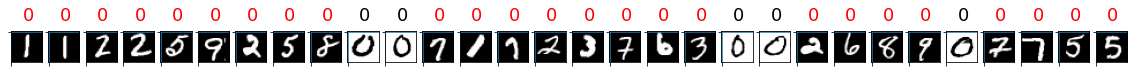

In [49]:
# predict using the deployed model
# sanity check
result = defenseservice.run(input_data=test_samples)
print(result)

# # compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

In [50]:
def pred_without_ais(data):
    test_samples = json.dumps({"data": data.tolist()})
    test_samples = bytes(test_samples, encoding='utf8')

    # predict using the deployed model
    # sanity check
    result = service.run(input_data=test_samples)
    return result

In [72]:
def pred_with_ais(data):
    test_samples = json.dumps({"data": data.tolist()})
    test_samples = bytes(test_samples, encoding='utf8')

    # predict using the deployed model
    # sanity check
    defense_prediction = defenseservice.run(input_data=test_samples)
    print(defense_prediction)

    # passing to AIS-defense model
#     defense_prediction = defenseservice.run(data)
    # passing to actual model
    orig_prediction = service.run(input_data=test_samples)
    print(orig_prediction)
    # Manipulating actual prediction based on defense model prediction
    prediction=list()
    for idx, def_pred in enumerate(defense_prediction):
        if def_pred==1:
            prediction.append('Attack')
        else:
            prediction.append(orig_prediction[idx])
        
#     prediction = ['Attack' if def_pred==1 else orig_prediction[idx] for idx, def_pred in enumerate(defense_prediction)]
    return prediction

### `creation of attack queries`

In [81]:
'''
Description: Create quereis for model extraction
'''
attack_queries = np.random.rand(25,28,28,1)*0
for i in (range(attack_queries.shape[0])):
    for _ in range(np.random.randint(0,20)):
        x1 = np.random.randint(0,20)
        y1 = np.random.randint(0,20)
        x2 = np.random.randint(x1,28)
        y2 = np.random.randint(y1,28)
        attack_queries[i,x1:x2,y1:y2,0] = 7

In [82]:
# prediction without AIS integrationa
pred_wo_ais = pred_without_ais(attack_queries)
print(pred_wo_ais)

[6, 1, 1, 0, 2, 7, 1, 2, 8, 6, 1, 2, 3, 7, 2, 1, 2, 2, 7, 7, 0, 4, 8, 0, 0]


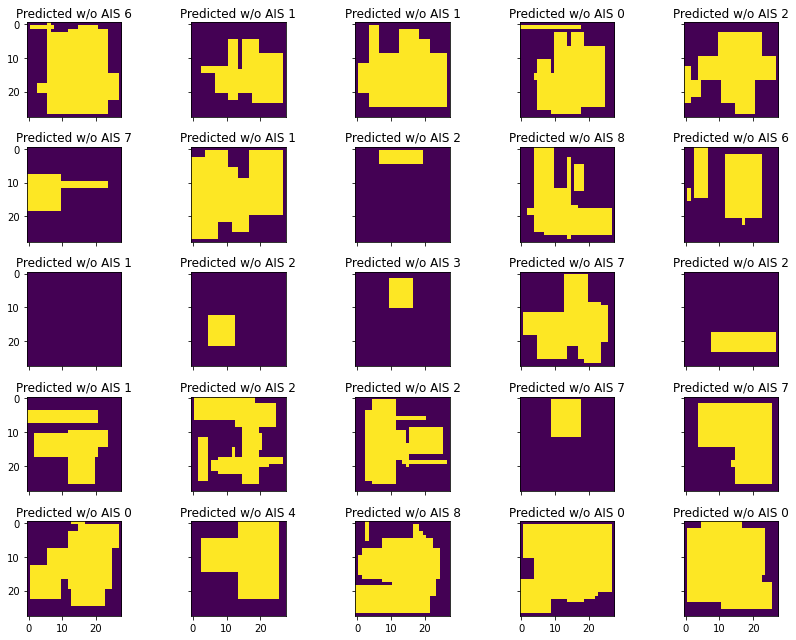

In [83]:
rows = 5
fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(attack_queries[i,:])
    axs[subplot_row,subplot_col].set_title("Predicted w/o AIS %d" % pred_wo_ais[i])
plt.tight_layout()

In [84]:
# prediction with AIS integration
pred_ais = pred_with_ais(attack_queries)
print(pred_ais)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
[6, 1, 1, 0, 2, 7, 1, 2, 8, 6, 1, 2, 3, 7, 2, 1, 2, 2, 7, 7, 0, 4, 8, 0, 0]
['Attack', 'Attack', 'Attack', 0, 'Attack', 'Attack', 'Attack', 'Attack', 'Attack', 'Attack', 'Attack', 'Attack', 'Attack', 'Attack', 'Attack', 'Attack', 2, 'Attack', 'Attack', 'Attack', 0, 'Attack', 'Attack', 'Attack', 'Attack']


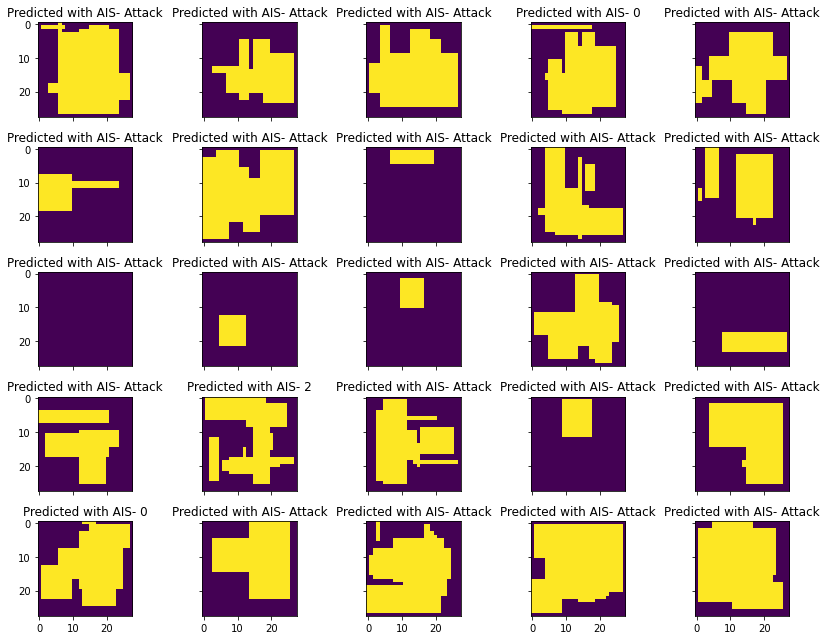

In [85]:
rows = 5
fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(attack_queries[i,:])
    axs[subplot_row,subplot_col].set_title("Predicted with AIS- %s" % str(pred_ais[i]))
plt.tight_layout()

### `deleting the services`

In [86]:
service.delete()

In [87]:
defenseservice.delete()